# Run the Analog Forecast

Use this notebook to run the analog forecast for any date that is not present in the historical dataset. I.e., if you want to make an actualy forecast, or a hindcast for some date in 2022.

In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from scripts.download_era5 import download
from config import data_dir
import luts
import analog_forecast as af

Set the options for the forecast:

In [2]:
varname = "t2m"
spatial_domain = "alaska"
ref_date = "2023-03-22"
use_anom = False

Download ERA5 data for the reference date:

In [3]:
%%time
bbox = list(luts.spatial_domains[spatial_domain]["bbox"])
# ERA5 at CDS API needs [N, W, S, E]
bbox = [bbox[-1]] + bbox[:3] 

ref_date = pd.to_datetime(ref_date)
cretrieve_kwargs = {   
    "product_type": "reanalysis",
    "format": "netcdf",
    # only going through 2022 right now to avoid getting "expver=5" (initial release data)
    "year": ref_date.year,
    "month": str(ref_date.month).zfill(2),
    "day": str(ref_date.day).zfill(2),
    "time": "12:00",
    "area": bbox,
}

out_paths = download(
    data_dir,
    dataset=luts.varnames_lu[varname]["era5_dataset_name"],
    varnames=luts.varnames_lu[varname]["era5_long_name"],
    cretrieve_kwargs=cretrieve_kwargs,
    fn_suffix=f"{ref_date.strftime('%Y%m%d')}"
)

CPU times: user 249 ms, sys: 17.2 ms, total: 266 ms
Wall time: 2.78 s


Now load this downloaded data:

In [4]:
ref_fp = out_paths[0]
ref_da = xr.load_dataset(ref_fp)[varname]

And also load the historical data:

In [5]:
%%time
sub_da = af.read_subset_era5(spatial_domain, data_dir, varname, use_anom=use_anom)
# need to load and subset raw data as wel for forecast with anomaly based search
if use_anom:
    raw_sub_da = af.read_subset_era5(spatial_domain, data_dir, varname, use_anom=False)
    # compute the climatology from the raw data for the day of year of the reference date
    clim_da = raw_sub_da.sel(time=raw_sub_da.time[sub_da.dayofyear == ref_date.dayofyear]).mean(dim="time")
    ref_anom_da = ref_da - clim_da
    # append this to the sub_da
    sub_da = xr.concat([sub_da.drop("dayofyear"), ref_anom_da], dim="time")
else:
    raw_sub_da = sub_da

CPU times: user 11.2 ms, sys: 5.59 ms, total: 16.7 ms
Wall time: 13 ms


Now create the forecast:

In [58]:
%%time
analogs = af.find_analogs(sub_da, print_analogs=True, ref_da=ref_da)
forecast = af.make_forecast(raw_sub_da, analogs.time.values, ref_date.strftime('%Y-%m-%d')) - 273.15

   Top 5 Analogs: 
Rank 1:   Date: 1975-04-22;  RMSE: 2.826
Rank 2:   Date: 2013-04-20;  RMSE: 2.957
Rank 3:   Date: 2011-03-25;  RMSE: 3.050
Rank 4:   Date: 1986-04-22;  RMSE: 3.092
Rank 5:   Date: 1977-04-28;  RMSE: 3.097
CPU times: user 6.96 s, sys: 5.99 s, total: 13 s
Wall time: 13 s


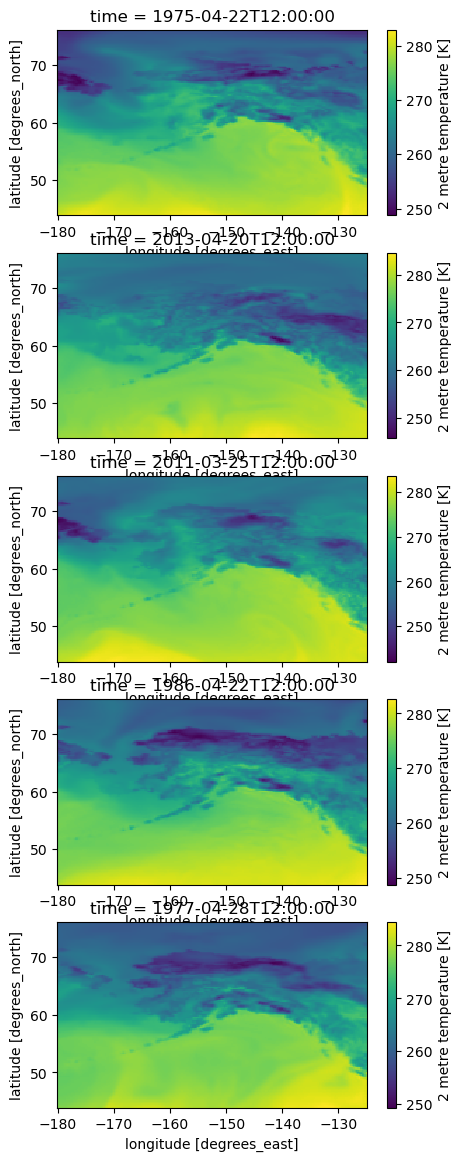

In [59]:
fig, ax = plt.subplots(5, 1, figsize=(5, 14))

for t, a in zip(analogs.time.values, ax):
    raw_sub_da.sel(time=t).plot(ax=a)

end